In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.tom

In [ ]:
import time
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import torch
import time
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from datasets import load_dataset



In [ ]:

# Load model and tokenizer
model_name = "gpt2"  # Replace with your LLM
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
import torch
import numpy as np
import time
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from datasets import load_dataset

class QuantizedModelPipeline:
    def __init__(self, model_name, quantization_config=None, max_tokens=64):
        self.model_name = model_name
        self.quantization_config = quantization_config
        self.max_tokens = max_tokens
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tokenizer = None
        self.model_size_mb = None

    def load_quantized_model(self):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_fast=True)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            quantization_config=self.quantization_config,
            device_map="auto",
            torch_dtype=torch.bfloat16 if "4bit" in str(self.quantization_config) or "8bit" in str(self.quantization_config) else torch.float32
        )
        self.model.eval()
        print(f"Loaded model: {self.model_name} with quantization.")

        # Calculate model size
        self.model_size_mb = self._calculate_model_size()
        print(f"Model size after quantization: {self.model_size_mb:.2f} MB")

    def _calculate_model_size(self):
        """Estimates the model size in MB by summing all parameter sizes."""
        param_size = 0
        for param in self.model.parameters():
            param_size += param.nelement() * param.element_size()
        return param_size / (1024 ** 2)  # Convert bytes to megabytes

    def calculate_perplexity(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(self.device)
        with torch.no_grad():
            start_time = time.time()
            outputs = self.model(**inputs, labels=inputs["input_ids"])
            end_time = time.time()
        loss = outputs.loss.item()
        return np.exp(loss), end_time - start_time

def evaluate_squad_perplexity(pipeline, output_file_path, max_samples=100):
    dataset = load_dataset("squad", split="validation[:{}]".format(max_samples))

    metrics = []
    total_time = 0.0

    for idx, example in enumerate(dataset):
        input_text = example["context"]

        ppl, elapsed_time = pipeline.calculate_perplexity(input_text)
        total_time += elapsed_time

        metrics.append({
            "index": idx,
            "perplexity": ppl,
            "time_taken_sec": elapsed_time
        })

        if idx % 10 == 0:
            print(f"Processed {idx} examples...")

    # Save metrics into text file
    with open(output_file_path, "w") as f:
        f.write(f"Model Name: {pipeline.model_name}\n")
        f.write(f"Quantization Config: {pipeline.quantization_config}\n")
        f.write(f"Model Size After Quantization: {pipeline.model_size_mb:.2f} MB\n\n")

        for entry in metrics:
            f.write(f"Example {entry['index']}:\n")
            f.write(f"  Perplexity: {entry['perplexity']:.4f}\n")
            f.write(f"  Time Taken (s): {entry['time_taken_sec']:.4f}\n")
            f.write("\n")

        f.write(f"Total Examples: {len(metrics)}\n")
        f.write(f"Total Time (s): {total_time:.4f}\n")
        f.write(f"Average Time per Example (s): {total_time/len(metrics):.4f}\n")

    print(f"Saved metrics to {output_file_path}")



In [ ]:
def run_all_quantization_experiments(model_name="gpt2", output_dir="results", max_samples=100):
    os.makedirs(output_dir, exist_ok=True)

    quantization_settings = {
        "baseline_full_precision": None,  # Baseline (no quantization)
        "8bit": BitsAndBytesConfig(load_in_8bit=True),
        "4bit_fp4": BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="fp4", bnb_4bit_compute_dtype=torch.bfloat16),
        "4bit_nf4": BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16),
    }

    for name, quant_config in quantization_settings.items():
        print(f"\n\nRunning for config: {name}\n{'='*50}")
        pipeline = QuantizedModelPipeline(model_name=model_name, quantization_config=quant_config)
        pipeline.load_quantized_model()

        output_file = os.path.join(output_dir, f"{model_name.replace('/', '_')}_{name}_metrics.txt")
        evaluate_squad_perplexity(pipeline, output_file_path=output_file, max_samples=max_samples)


In [ ]:
run_all_quantization_experiments(model_name="gpt2", output_dir="quantization_results", max_samples=100)




Running for config: baseline_full_precision
Loaded model: gpt2 with quantization.
Model size after quantization: 474.70 MB
Processed 0 examples...
Processed 10 examples...
Processed 20 examples...
Processed 30 examples...
Processed 40 examples...
Processed 50 examples...
Processed 60 examples...
Processed 70 examples...
Processed 80 examples...
Processed 90 examples...
Saved metrics to quantization_results/gpt2_baseline_full_precision_metrics.txt


Running for config: 8bit
Loaded model: gpt2 with quantization.
Model size after quantization: 156.35 MB
Processed 0 examples...
Processed 10 examples...
Processed 20 examples...
Processed 30 examples...
Processed 40 examples...
Processed 50 examples...
Processed 60 examples...
Processed 70 examples...
Processed 80 examples...
Processed 90 examples...
Saved metrics to quantization_results/gpt2_8bit_metrics.txt


Running for config: 4bit_fp4
Loaded model: gpt2 with quantization.
Model size after quantization: 115.85 MB
Processed 0 examples..

In [ ]:
import os
import time
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

class QuantizedModelPipeline:
    def __init__(self, model_name, quantization_config=None, max_tokens=64):
        self.model_name = model_name
        self.quantization_config = quantization_config
        self.max_tokens = max_tokens
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tokenizer = None
        self.model_size_mb = None  # Track model size

    def load_quantized_model(self):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_fast=True)

        if self.quantization_config is None:
            # Full precision baseline
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                device_map="auto",
                torch_dtype=torch.float32
            )
            print(f"Loaded full-precision baseline model: {self.model_name}")
        else:
            # Quantized model
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                quantization_config=self.quantization_config,
                device_map="auto",
                torch_dtype=torch.bfloat16
            )
            print(f"Loaded quantized model: {self.model_name}")

        self.model.eval()
        self.model_size_mb = self._calculate_model_size()
        print(f"Model size after loading: {self.model_size_mb:.2f} MB")

    def _calculate_model_size(self):
        param_size = 0
        for param in self.model.parameters():
            param_size += param.nelement() * param.element_size()
        return param_size / (1024 ** 2)  # Convert to MB

    def calculate_perplexity(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(self.device)
        with torch.no_grad():
            start_time = time.time()
            outputs = self.model(**inputs, labels=inputs["input_ids"])
            end_time = time.time()
        loss = outputs.loss.item()
        return np.exp(loss), end_time - start_time

    def generate_and_evaluate_bleu(self, input_text, reference_text):
        inputs = self.tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=512).to(self.device)

        start_time = time.time()
        outputs = self.model.generate(inputs, max_new_tokens=self.max_tokens)
        end_time = time.time()

        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        smoothie = SmoothingFunction().method4
        reference = [reference_text.split()]
        candidate = generated_text.split()
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)

        return generated_text, bleu_score, end_time - start_time

    def evaluate_sample(self, input_text, reference_text):
        ppl, ppl_time = self.calculate_perplexity(input_text)
        generated_text, bleu, gen_time = self.generate_and_evaluate_bleu(input_text, reference_text)

        return {
            "generated": generated_text,
            "perplexity": ppl,
            "perplexity_time": ppl_time,
            "bleu_score": bleu,
            "generation_time": gen_time,
            "model_size_mb": self.model_size_mb
        }

    def compute_layerwise_importance(self, text):
        print("\n🔍 Computing layerwise importance (Ablation)...")
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(self.device)
        labels = inputs["input_ids"]

        with torch.no_grad():
            full_output = self.model(**inputs, labels=labels)
            base_loss = full_output.loss.item()

        importance_scores = {}

        try:
            layers = self.model.model.layers  # LLaMA, OPT
        except AttributeError:
            layers = self.model.transformer.h  # GPT-2, etc.

        for i, layer in enumerate(layers):
            def forward_hook(module, input, output):
                if isinstance(output, tuple):
                    return tuple(torch.zeros_like(t) if isinstance(t, torch.Tensor) else t for t in output)
                return torch.zeros_like(output) if isinstance(output, torch.Tensor) else output

            handle = layer.register_forward_hook(forward_hook)

            with torch.no_grad():
                ablated_output = self.model(**inputs, labels=labels)
                ablated_loss = ablated_output.loss.item()

            delta = ablated_loss - base_loss
            importance_scores[i] = delta

            handle.remove()
            print(f"Layer {i}: ΔLoss = {delta:.4f}")

        return importance_scores

    def compute_importance_by_gradient_diff(self, text):
        print("\n🔍 Computing gradient-difference-based importance...")
        self.model.train()

        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(self.device)
        labels = inputs["input_ids"]

        self.model.zero_grad()
        outputs = self.model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()

        baseline_grads = {}
        for name, param in self.model.named_parameters():
            if param.grad is not None:
                baseline_grads[name] = param.grad.detach().clone()

        importance_scores = {}

        try:
            layers = self.model.model.layers
        except AttributeError:
            layers = self.model.transformer.h

        for i, layer in enumerate(layers):
            self.model.zero_grad()

            def hook_fn(module, input, output):
                if isinstance(output, tuple):
                    return (output[0] * 0.5,)
                return output * 0.5

            handle = layer.register_forward_hook(hook_fn)

            perturbed_outputs = self.model(**inputs, labels=labels)
            perturbed_loss = perturbed_outputs.loss
            perturbed_loss.backward()

            grad_diff = 0.0
            for name, param in self.model.named_parameters():
                if param.grad is not None and name in baseline_grads:
                    diff = param.grad - baseline_grads[name]
                    grad_diff += torch.norm(diff, p=2).item()

            importance_scores[i] = grad_diff
            handle.remove()
            print(f"Layer {i}: ∥Δgrad∥₂ = {grad_diff:.4f}")

        self.model.eval()
        return importance_scores

    def print_model_layers(self):
        print(f"\n📚 Model Layers in: {self.model_name}")
        print("=" * 50)
        for name, module in self.model.named_modules():
            print(name)


In [ ]:
import json
import os
from transformers import BitsAndBytesConfig

# Your model (e.g., "gpt2", "facebook/opt-125m", "meta-llama/Llama-2-7b-chat-hf")
MODEL_NAME = "gpt2"
RESULTS_FILE = "quantization_experiment_results.json"

# Example input (can be replaced by any SQuAD sample)
INPUT_TEXT = "What is the capital of France?"
REFERENCE_TEXT = "The capital of France is Paris."

# Different quantization settings
experiments = {
    "baseline": None,  # Full precision
    "8bit": BitsAndBytesConfig(load_in_8bit=True),
    "4bit": BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_quant_type="nf4")
}

# Storage
all_results = {}

for exp_name, quant_config in experiments.items():
    print("\n" + "="*60)
    print(f"🚀 Running experiment: {exp_name}")
    print("="*60)

    # Initialize
    pipeline = QuantizedModelPipeline(model_name=MODEL_NAME, quantization_config=quant_config)
    pipeline.load_quantized_model()

    # Evaluate
    metrics = pipeline.evaluate_sample(INPUT_TEXT, REFERENCE_TEXT)

    # Compute layerwise importance (ΔLoss Ablation)
    layerwise_importance = pipeline.compute_layerwise_importance(INPUT_TEXT)

    # Optionally: Compute gradient-diff importance (commented)
    # gradient_importance = pipeline.compute_importance_by_gradient_diff(INPUT_TEXT)

    # Save all info
    all_results[exp_name] = {
        "perplexity": metrics["perplexity"],
        "perplexity_time": metrics["perplexity_time"],
        "bleu_score": metrics["bleu_score"],
        "generation_time": metrics["generation_time"],
        "model_size_mb": metrics["model_size_mb"],
        "layerwise_importance": layerwise_importance,
        # "gradient_importance": gradient_importance,  # if needed
    }

    # Cleanup memory
    del pipeline
    torch.cuda.empty_cache()

# Save final results
with open(RESULTS_FILE, "w") as f:
    json.dump(all_results, f, indent=2)

print(f"\n✅ Finished all experiments. Results saved to {RESULTS_FILE}")



🚀 Running experiment: baseline


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Loaded full-precision baseline model: gpt2
Model size after loading: 474.70 MB

🔍 Computing layerwise importance (Ablation)...
Layer 0: ΔLoss = 2.9979
Layer 1: ΔLoss = 3.8043
Layer 2: ΔLoss = 9.3670
Layer 3: ΔLoss = 11.8499
Layer 4: ΔLoss = 10.1738
Layer 5: ΔLoss = 5.6579
Layer 6: ΔLoss = 6.9498
Layer 7: ΔLoss = 5.2823
Layer 8: ΔLoss = 8.3640
Layer 9: ΔLoss = 5.8183
Layer 10: ΔLoss = 4.5460
Layer 11: ΔLoss = 3.5939

🚀 Running experiment: 8bit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Loaded quantized model: gpt2
Model size after loading: 156.35 MB

🔍 Computing layerwise importance (Ablation)...
Layer 0: ΔLoss = 2.9469
Layer 1: ΔLoss = 3.7028
Layer 2: ΔLoss = 9.9072
Layer 3: ΔLoss = 11.0400
Layer 4: ΔLoss = 10.1421
Layer 5: ΔLoss = 5.6601
Layer 6: ΔLoss = 6.8490
Layer 7: ΔLoss = 4.6150
Layer 8: ΔLoss = 8.6627
Layer 9: ΔLoss = 5.8581
Layer 10: ΔLoss = 4.4466
Layer 11: ΔLoss = 3.5155

🚀 Running experiment: 4bit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Loaded quantized model: gpt2
Model size after loading: 115.85 MB

🔍 Computing layerwise importance (Ablation)...
Layer 0: ΔLoss = 2.9262
Layer 1: ΔLoss = 3.8187
Layer 2: ΔLoss = 10.4104
Layer 3: ΔLoss = 9.2654
Layer 4: ΔLoss = 10.1684
Layer 5: ΔLoss = 4.2935
Layer 6: ΔLoss = 7.4407
Layer 7: ΔLoss = 4.1933
Layer 8: ΔLoss = 8.6961
Layer 9: ΔLoss = 5.4314
Layer 10: ΔLoss = 4.5659
Layer 11: ΔLoss = 3.4950

✅ Finished all experiments. Results saved to quantization_experiment_results.json


In [ ]:
import itertools
import torch
import time
import json
from transformers import AutoTokenizer, AutoModelForCausalLM

class LayerwiseAblationStudy:
    def __init__(self, model_name, quantization_config=None, max_combination_size=2, output_file="ablation_results.json"):
        self.model_name = model_name
        self.quantization_config = quantization_config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tokenizer = None
        self.max_combination_size = max_combination_size  # Up to how many layers to combine
        self.output_file = output_file  # New: path to save results

    def load_model(self):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_fast=True)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            quantization_config=self.quantization_config,
            device_map="auto",
            torch_dtype=torch.bfloat16 if self.quantization_config else torch.float32
        )
        self.model.eval()
        print(f"✅ Loaded model {self.model_name} with quantization: {self.quantization_config}")

    def compute_loss(self, input_text):
        inputs = self.tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss.item()
        return loss

    def ablation_study(self, input_text):
        print(f"🔍 Starting ablation study (max_combination_size={self.max_combination_size})...")

        base_loss = self.compute_loss(input_text)
        print(f"🎯 Base loss: {base_loss:.4f}")

        try:
            layers = self.model.model.layers  # LLaMA, OPT
        except AttributeError:
            layers = self.model.transformer.h  # GPT-2, DistilGPT2

        num_layers = len(layers)
        print(f"📚 Total layers: {num_layers}")

        ablation_results = {}

        # Initialize output file
        self.initialize_output_file(base_loss)

        # Go through combinations
        for r in range(1, self.max_combination_size + 1):
            for layer_indices in itertools.combinations(range(num_layers), r):
                print(f"⚡ Masking layers: {layer_indices}")

                handles = []
                for idx in layer_indices:
                    handle = layers[idx].register_forward_hook(self.mask_hook)
                    handles.append(handle)

                ablated_loss = self.compute_loss(input_text)
                delta_loss = ablated_loss - base_loss

                combo_key = str(layer_indices)
                result = {
                    "ablated_loss": ablated_loss,
                    "delta_loss": delta_loss
                }
                ablation_results[combo_key] = result

                # Append result immediately to file
                self.append_result_to_file(combo_key, result)

                # Remove hooks
                for handle in handles:
                    handle.remove()

        print("✅ Ablation study completed.")
        return ablation_results

    def initialize_output_file(self, base_loss):
        """Initialize output JSON file with base loss."""
        try:
            with open(self.output_file, "w") as f:
                json.dump({
                    "base_loss": base_loss,
                    "results": {}
                }, f, indent=2)
        except Exception as e:
            print(f"❌ Failed to initialize output file: {e}")

    def append_result_to_file(self, combo_key, result):
        """Append one result to output file safely."""
        try:
            with open(self.output_file, "r") as f:
                data = json.load(f)
        except (FileNotFoundError, json.JSONDecodeError):
            data = {"base_loss": None, "results": {}}

        data["results"][combo_key] = result

        with open(self.output_file, "w") as f:
            json.dump(data, f, indent=2)

    @staticmethod
    def mask_hook(module, input, output):
        if isinstance(output, tuple):
            return tuple(torch.zeros_like(t) if isinstance(t, torch.Tensor) else t for t in output)
        return torch.zeros_like(output) if isinstance(output, torch.Tensor) else output


In [ ]:
from transformers import BitsAndBytesConfig

model_name = "gpt2"
input_text = "The theory of relativity was proposed by"

# Example quantization config (optional)
quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)

# Create the study object
ablation_study = LayerwiseAblationStudy(
    model_name=model_name,
    quantization_config=quant_config,
    max_combination_size=2,   # (careful, combinations grow fast!)
    output_file="my_ablation_results.json"
)

ablation_study.load_model()
results = ablation_study.ablation_study(input_text)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Loaded model gpt2 with quantization: BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "bfloat16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "fp4",
  "bnb_4bit_use_double_quant": false,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}

🔍 Starting ablation study (max_combination_size=2)...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


🎯 Base loss: 4.1332
📚 Total layers: 12
⚡ Masking layers: (0,)
⚡ Masking layers: (1,)
⚡ Masking layers: (2,)
⚡ Masking layers: (3,)
⚡ Masking layers: (4,)
⚡ Masking layers: (5,)
⚡ Masking layers: (6,)
⚡ Masking layers: (7,)
⚡ Masking layers: (8,)
⚡ Masking layers: (9,)
⚡ Masking layers: (10,)
⚡ Masking layers: (11,)
⚡ Masking layers: (0, 1)
⚡ Masking layers: (0, 2)
⚡ Masking layers: (0, 3)
⚡ Masking layers: (0, 4)
⚡ Masking layers: (0, 5)
⚡ Masking layers: (0, 6)
⚡ Masking layers: (0, 7)
⚡ Masking layers: (0, 8)
⚡ Masking layers: (0, 9)
⚡ Masking layers: (0, 10)
⚡ Masking layers: (0, 11)
⚡ Masking layers: (1, 2)
⚡ Masking layers: (1, 3)
⚡ Masking layers: (1, 4)
⚡ Masking layers: (1, 5)
⚡ Masking layers: (1, 6)
⚡ Masking layers: (1, 7)
⚡ Masking layers: (1, 8)
⚡ Masking layers: (1, 9)
⚡ Masking layers: (1, 10)
⚡ Masking layers: (1, 11)
⚡ Masking layers: (2, 3)
⚡ Masking layers: (2, 4)
⚡ Masking layers: (2, 5)
⚡ Masking layers: (2, 6)
⚡ Masking layers: (2, 7)
⚡ Masking layers: (2, 8)
⚡ Ma

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_ablation_heatmap(result_file, max_layer=None):
    # Load results
    with open(result_file, "r") as f:
        data = json.load(f)

    results = data["results"]

    # Determine number of layers if not given
    if max_layer is None:
        all_layers = set()
        for key in results.keys():
            layers = eval(key)  # careful: key was saved as string like "(1, 2)"
            all_layers.update(layers)
        max_layer = max(all_layers) + 1

    print(f"Detected {max_layer} layers.")

    # Initialize matrix
    heatmap = np.zeros((max_layer, max_layer))

    # Fill matrix
    for key, value in results.items():
        layers = eval(key)
        delta_loss = value["delta_loss"]

        if len(layers) == 1:
            i = layers[0]
            heatmap[i, i] = delta_loss
        elif len(layers) == 2:
            i, j = layers
            heatmap[i, j] = delta_loss
            heatmap[j, i] = delta_loss  # Symmetric for pairs

    # Plot
    plt.figure(figsize=(12, 10))
    plt.title("Layerwise Ablation ΔLoss Heatmap", fontsize=16)
    plt.xlabel("Layer Index", fontsize=14)
    plt.ylabel("Layer Index", fontsize=14)
    plt.imshow(heatmap, cmap="viridis", interpolation="nearest")
    plt.colorbar(label="Delta Loss (masked vs base)")
    plt.xticks(np.arange(max_layer))
    plt.yticks(np.arange(max_layer))
    plt.grid(False)
    plt.show()



Detected 12 layers.


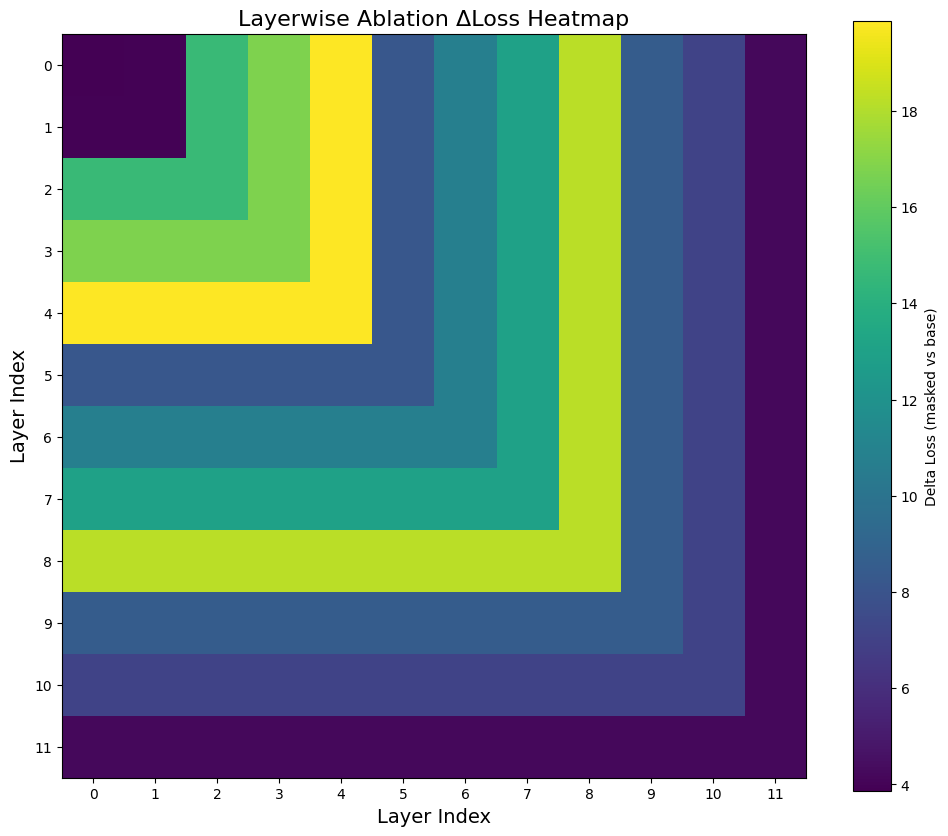

In [ ]:
plot_ablation_heatmap("my_ablation_results.json")


In [ ]:
from transformers import BitsAndBytesConfig

model_name = "gpt2"
input_text = "The theory of relativity was proposed by"

# Example quantization config (optional)
quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)

# Create the study object
ablation_study = LayerwiseAblationStudy(
    model_name=model_name,
    quantization_config=quant_config,
    max_combination_size=4,   # (careful, combinations grow fast!)
    output_file="my_ablation_results-4.json"
)

ablation_study.load_model()
results = ablation_study.ablation_study(input_text)


✅ Loaded model gpt2 with quantization: BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "bfloat16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "fp4",
  "bnb_4bit_use_double_quant": false,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}

🔍 Starting ablation study (max_combination_size=4)...
🎯 Base loss: 4.1332
📚 Total layers: 12
⚡ Masking layers: (0,)
⚡ Masking layers: (1,)
⚡ Masking layers: (2,)
⚡ Masking layers: (3,)
⚡ Masking layers: (4,)
⚡ Masking layers: (5,)
⚡ Masking layers: (6,)
⚡ Masking layers: (7,)
⚡ Masking layers: (8,)
⚡ Masking layers: (9,)
⚡ Masking layers: (10,)
⚡ Masking layers: (11,)
⚡ Masking layers: (0, 1)
⚡ Masking layers: (0, 2)
⚡ Masking layers: (0, 3)
⚡ Masking layers: (0, 4)
⚡ Masking layers: (0, 5)
⚡ Masking layers:

In [ ]:
import json
import itertools
import numpy as np

def compute_shapley_values(result_file):
    # Load ablation results
    with open(result_file, "r") as f:
        data = json.load(f)

    results = data["results"]

    # Extract layers and their associated losses (delta_loss)
    layer_combinations = {}
    for key, value in results.items():
        layers = eval(key)  # Convert string representation to tuple (layer indices)
        delta_loss = value["delta_loss"]
        layer_combinations[layers] = delta_loss

    # Get all layers involved
    all_layers = set()
    for layers in layer_combinations.keys():
        all_layers.update(layers)
    all_layers = sorted(list(all_layers))

    # Initialize dictionary to store Shapley values
    shapley_values = {layer: 0 for layer in all_layers}

    # Total number of combinations to consider
    num_combinations = 0

    # Loop over all non-empty subsets of layers
    for r in range(1, len(all_layers) + 1):
        for comb in itertools.combinations(all_layers, r):
            num_combinations += 1
            comb_loss = layer_combinations.get(comb, 0)

            # For each layer, calculate marginal contribution
            for layer in comb:
                # Create a subset of the combination excluding the current layer
                reduced_comb = tuple(l for l in comb if l != layer)
                reduced_comb_loss = layer_combinations.get(reduced_comb, 0)

                # Calculate marginal contribution
                marginal_contribution = comb_loss - reduced_comb_loss
                shapley_values[layer] += marginal_contribution

    # Normalize by the number of combinations
    for layer in shapley_values:
        shapley_values[layer] /= num_combinations

    # Return Shapley values
    return shapley_values


In [ ]:
shapley_values = compute_shapley_values("my_ablation_results-4.json")
print(shapley_values)


{0: -0.6429873982337514, 1: -0.6429347945365859, 2: -0.6324638697399471, 3: -0.6283711346077832, 4: -0.6163314320956685, 5: -0.7015970213800414, 6: -0.669330786028479, 7: -0.6227163787580963, 8: -0.46090790186172875, 9: -0.9002119183103681, 10: -0.9941045153272021, 11: -1.2408830738184071}
